In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"

JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [3]:
import jaxley as jx
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

In [4]:
from examples.Park_2019.biophys.python.Najx import Na
from examples.Park_2019.biophys.python.Kvjx import Kv
from examples.Park_2019.biophys.python.Kmjx import Km
from examples.Park_2019.biophys.python.KCajx import KCa
from examples.Park_2019.biophys.python.Kajx import Ka
from examples.Park_2019.biophys.python.CaLVAjx import CaLVA
from examples.Park_2019.biophys.python.CaHVAjx import CaHVA
from jaxley.channels import Leak

5 MultiCompartment Model 

In [5]:
soma_branch = jx.Branch([jx.Compartment()]) # 1 comp
basal_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps
apic_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps

cell = jx.Cell([soma_branch, basal_branch, apic_branch], parents=[-1, 0, 0])


In [6]:
temperature = 37.0

channels = [Na(), Kv(), Km(), Ka()]  

for ch in channels:
    if hasattr(ch, "set_tadj"):
        try: ch.set_tadj(temperature)
        except: pass
    ch.temperature = temperature  # needed for Ka

cell.insert(Leak())
for ch in channels:
    cell.insert(ch)

In [7]:
v_init = -79.0
Rm = 11000.0
Ri = 100.0
Cm = 1.0

cell.set("v", v_init)
cell.set("axial_resistivity", Ri) 
cell.branch(0).set("capacitance", Cm)  # soma: 1
cell.branch(1).set("capacitance", 2 * Cm) # dend: 2
cell.branch(2).set("capacitance", 2 * Cm) # dend: 2


In [8]:
# soma
cell.branch(0).comp(0).set("length", 20)
cell.branch(0).comp(0).set("radius", 6)

cell.branch(1).comp(0).set("length", 100.0)   # prox
cell.branch(1).comp(0).set("radius", 0.50)
cell.branch(1).comp(1).set("length", 100.0)   # dist
cell.branch(1).comp(1).set("radius", 0.50)


cell.branch(2).comp(0).set("length", 100.0)   # prox
cell.branch(2).comp(0).set("radius", 0.50)
cell.branch(2).comp(1).set("length", 100.0)   # dist
cell.branch(2).comp(1).set("radius", 0.50)

In [9]:
print("soma:")
print(cell.branch(0).nodes[["length","radius", "capacitance"]])
print("basal:")
print(cell.branch(1).nodes[["length","radius", "capacitance"]])
print("apical:")
print(cell.branch(2).nodes[["length","radius", "capacitance"]])

soma:
   length  radius  capacitance
0    20.0     6.0          1.0
basal:
   length  radius  capacitance
1   100.0     0.5          2.0
2   100.0     0.5          2.0
apical:
   length  radius  capacitance
3   100.0     0.5          2.0
4   100.0     0.5          2.0


In [10]:
Rm_scale = 100
cell.set("Leak_gLeak",(1.0 )/ (Rm * Rm_scale))
cell.set("Leak_eLeak", v_init) 

In [11]:
soma = cell.branch(0)
dend = [cell.branch(1), cell.branch(2)]

scale = 0.19

soma.set("gbar_Na", 504.9 * scale)
soma.set("gbar_Kv", 50.0 * scale)
soma.set("gbar_Km", 2.794)
soma.set("gbar_Ka", 0.0054)
# soma.set("gbar_KCa", 0.0)
# soma.set("gbar_CaHVA", 0.05)
# soma.set("gbar_CaLVA", 3e-5)

for br in dend:
    br.set("gbar_Na", 302.94 * scale)
    br.set("gbar_Kv", 1.5 * scale)
    br.set("gbar_Km", 1.27 )
    br.set("gbar_Ka", 0.108 )
    # br.set("gbar_KCa", 0.0)
    # br.set("gbar_CaHVA", 0.05)
    # br.set("gbar_CaLVA", 3e-5)

In [12]:
print(cell.nodes[["Leak_gLeak","Leak_eLeak","gbar_Na","gbar_Kv"]])

     Leak_gLeak  Leak_eLeak  gbar_Na  gbar_Kv
0  9.090909e-07       -79.0  95.9310    9.500
1  9.090909e-07       -79.0  57.5586    0.285
2  9.090909e-07       -79.0  57.5586    0.285
3  9.090909e-07       -79.0  57.5586    0.285
4  9.090909e-07       -79.0  57.5586    0.285


In [13]:
dt=0.025
I_amp = 0.01  # nA
t_max=200

I = jx.step_current(i_delay=100, i_dur=50, i_amp=I_amp, delta_t=dt, t_max=t_max)
cell.delete_stimuli(); cell.delete_recordings()
cell.branch(0).comp(0).stimulate(I)
cell.branch(0).comp(0).record("v")
v = np.array(jx.integrate(cell, delta_t=dt)).squeeze()
t = np.arange(v.shape[0])*dt
baseline = v[(t>80)&(t<95)].mean()
steady   = v[(t>140)&(t<150)].mean()
dV_mV = steady-baseline
Rin_MOhm = dV_mV / I_amp
print("dV (mV):", dV_mV, "Rin (MΩ):", Rin_MOhm)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
dV (mV): 0.03570433461777611 Rin (MΩ): 3.5704334617776112


In [14]:
dt = 0.025
t_max = 200.0
I0 = jx.step_current(i_delay=0.0, i_dur=0.0, i_amp=0.0, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I0) 
cell.branch(0).comp(0).record("v")
v = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


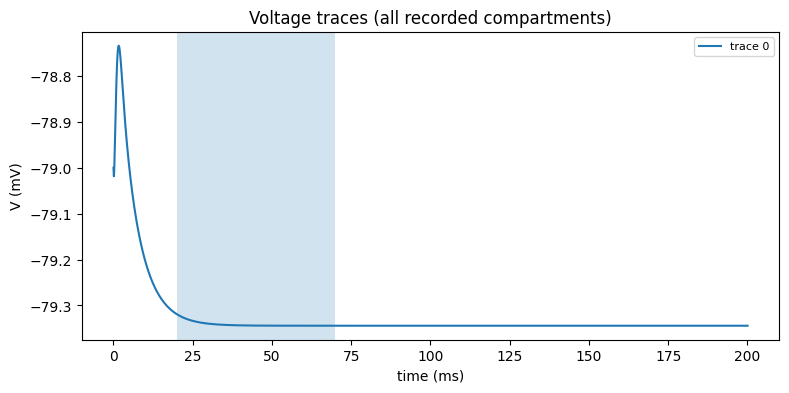

In [15]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [16]:
dt = 0.025
t_max = 200.0
I = jx.step_current(i_delay=0.0, i_dur=0.0, i_amp=0.0, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I)      # soma-only
cell.record("v")

v = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 5 recordings. See `.recordings` for details.


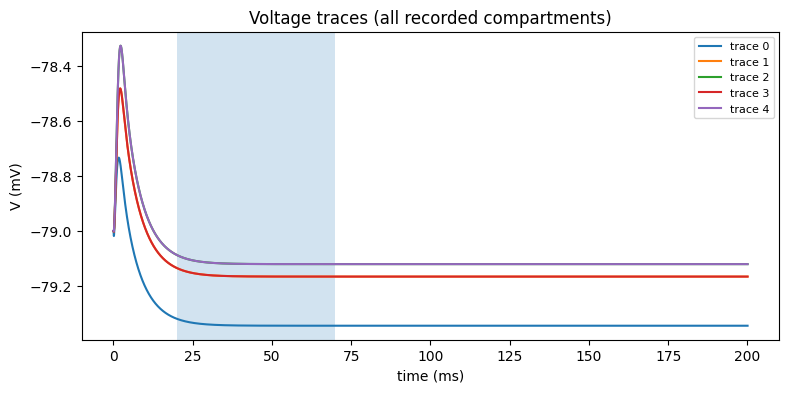

In [17]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [18]:
dt = 0.025
t_max = 200.0
I = jx.step_current(i_delay=100.0, i_dur=30.0, i_amp=0.2, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I)      # soma-only
cell.record("v")

v = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 5 recordings. See `.recordings` for details.


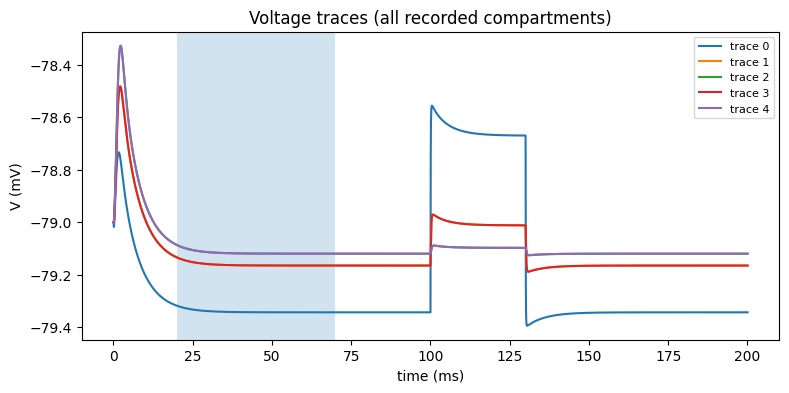

In [19]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [20]:
print(np.array(cell.externals["i"]).shape, np.array(cell.externals["i"]).max())

(1, 8001) 0.2


In [21]:
dt=0.025
I = jx.step_current(i_delay=100.0, i_dur=50.0, i_amp=0.01, delta_t=dt, t_max=200.0)

cell.delete_stimuli(); cell.delete_recordings()
cell.branch(0).comp(0).stimulate(I)
cell.branch(0).comp(0).record("v")
v = np.array(jx.integrate(cell, delta_t=dt)).squeeze()
t = np.arange(v.shape[0])*dt

baseline = v[(t>80)&(t<95)].mean()
steady   = v[(t>140)&(t<150)].mean()
dV = steady-baseline
Rin_MOhm = (0.01e-9)/(dV*1e-3) / 1e6
print("dV (mV):", dV, "Rin (MΩ):", Rin_MOhm)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
dV (mV): 0.03570433461777611 Rin (MΩ): 2.8007803834051287e-13


In [22]:
print("Leak_gLeak:", cell.nodes["Leak_gLeak"].iloc[0])

Leak_gLeak: 9.09090909090909e-07


In [23]:
print(cell.nodes[["Leak_gLeak","Leak_eLeak","gbar_Na","gbar_Kv"]])

     Leak_gLeak  Leak_eLeak  gbar_Na  gbar_Kv
0  9.090909e-07       -79.0  95.9310    9.500
1  9.090909e-07       -79.0  57.5586    0.285
2  9.090909e-07       -79.0  57.5586    0.285
3  9.090909e-07       -79.0  57.5586    0.285
4  9.090909e-07       -79.0  57.5586    0.285
